In [149]:
import copy
import pandas as pd
import seaborn as sns
import numpy as np
import openmatrix as omx
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd
%matplotlib inline

In [137]:
# Setup CTRAMP data
ctramp_trips = pd.read_csv('validation_output/ctramp/visitorTrips.csv')
ctramp_tours = pd.read_csv('validation_output/ctramp/visitorTours.csv')

ctramp_trips.period += 3 #This is to convert the CTRAMP from 40 to 48
ctramp_tours.departTime += 3 #This is to convert the CTRAMP from 40 to 48

mode_ids = {1: 'DRIVEALONE', 2:'SHARED2', 3:'SHARED3', 4:'WALK', 5:'BIKE', 6:'WALK_TRANSIT', 10:'TAXI', 11:'TNC_SINGLE', 12:'TNC_SHARED'}
purpose_ids = {-1: 'home', 0:'work', 1:'recreation', 2:'dining'}

ctramp_tours['tour_mode'] = ctramp_tours['tourMode'].map(mode_ids)
ctramp_trips['trip_mode'] = ctramp_trips['tripMode'].map(mode_ids)
ctramp_tours['tour_purpose'] = ctramp_tours['purpose'].map(purpose_ids)
ctramp_trips['orig_purpose'] = ctramp_trips['originPurp'].map(purpose_ids)
ctramp_trips['dest_purpose'] = ctramp_trips['destPurp'].map(purpose_ids)

In [138]:
# Load skims & landuse data
skims = omx.open_file('./traffic_skims_processed_AM.omx')
mazs = pd.read_csv('validation_output/asim/final_land_use.csv').rename(columns={'zone_id':'MAZ'}).set_index('MAZ')
maz_to_taz = mazs['TAZ']
maz_to_msa = mazs['pseudomsa']

In [139]:
ctramp_trips = ctramp_trips.merge(ctramp_tours, left_on='tourID', right_on='id', suffixes=('', '_tour'))

ctramp_tours.rename(columns={'originMGRA': 'origin', 'destinationMGRA': 'destination'}, inplace=True)
ctramp_trips.rename(columns={'originMGRA': 'origin', 'destinationMGRA': 'destination'}, inplace=True)

ctramp_trips['source'] = 'ctramp'
ctramp_tours['source'] = 'ctramp'

ctramp_tours['dest_taz'] = ctramp_tours['destination'].map(maz_to_taz)
ctramp_tours['orig_taz'] = ctramp_tours['origin'].map(maz_to_taz)
ctramp_trips['dest_taz'] = ctramp_trips['destination'].map(maz_to_taz)
ctramp_trips['orig_taz'] = ctramp_trips['origin'].map(maz_to_taz)

In [140]:
# Setup asim data
asim_trips = pd.read_csv('validation_output/asim/final_trips.csv')
asim_tours = pd.read_csv('validation_output/asim/final_tours.csv')

asim_trips = asim_trips.merge(asim_tours, left_on='tour_id', right_on='tour_id', suffixes=('', '_tour'))

asim_tours['dest_taz'] = asim_tours['destination'].map(maz_to_taz)
asim_tours['orig_taz'] = asim_tours['origin'].map(maz_to_taz)
asim_trips['dest_taz'] = asim_trips['destination'].map(maz_to_taz)
asim_trips['orig_taz'] = asim_trips['origin'].map(maz_to_taz)

asim_trips['source'] = 'asim'
asim_tours['source'] = 'asim'

## Overall Counts

ASIM tours:65712 // CTRAMP tours:70054 


<AxesSubplot:xlabel='Type', ylabel='Count'>

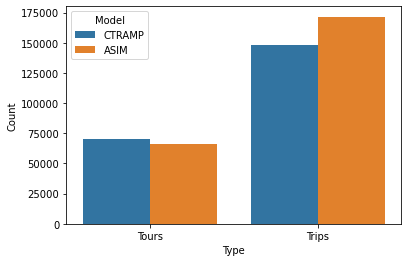

In [141]:
print('ASIM tours:{0} // CTRAMP tours:{1} '.format(len(ctramp_tours), len(asim_tours)))

tot_count = pd.DataFrame({'Type': ['Tours', 'Tours', 'Trips', 'Trips'],
                          'Model': ['CTRAMP', 'ASIM', 'CTRAMP', 'ASIM'],
                          'Count': [len(asim_tours), len(ctramp_tours), len(ctramp_trips), len(asim_trips)]})
sns.barplot(data=tot_count, x='Type', y='Count', hue='Model')

## Tour Scheduling 

Text(0.5, 0, 'tour departure hour')

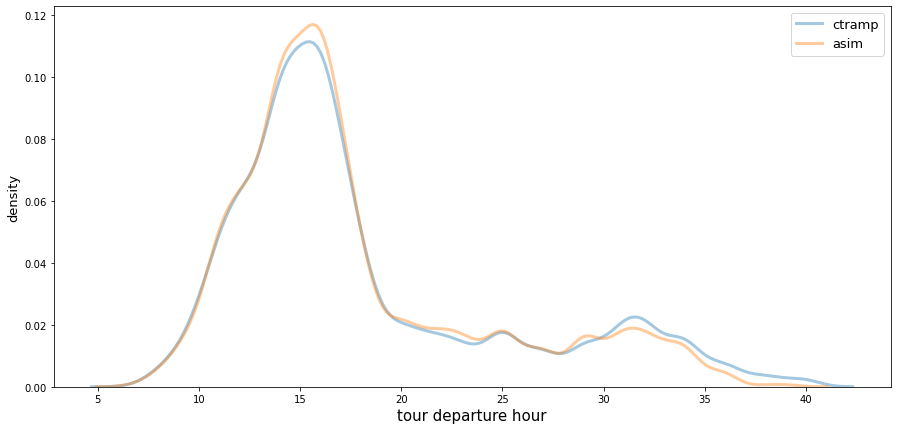

In [142]:
fig, ax = plt.subplots(figsize=(15,7))
sns.kdeplot(data=ctramp_tours, x='departTime', ax=ax, label='ctramp', alpha=0.4, lw=3, )
sns.kdeplot(data=asim_tours, x='start', ax=ax, label='asim', alpha=0.4, lw=3)
ax.legend(fontsize=13)
ax.set_ylabel('density', fontsize=13)
ax.set_xlabel('tour departure hour', fontsize=15)

## Tour OD 

In [143]:
# TAZ Aggregation
odmaz_asim = asim_tours.groupby(['orig_taz', 'dest_taz']).size().reset_index(name='asim_tours')
odmaz_ctramp = ctramp_tours.groupby(['orig_taz', 'dest_taz']).size().reset_index(name='ctramp_tours')

odtaz_compare = odmaz_asim.merge(odmaz_ctramp,
                                                     on=['orig_taz','dest_taz'],
                                                     how='outer').fillna(0)
otaz_compare = odtaz_compare.groupby('orig_taz')[['asim_tours', 'ctramp_tours']].agg('sum')
dtaz_compare = odtaz_compare.groupby('dest_taz')[['asim_tours', 'ctramp_tours']].agg('sum')
odtaz_compare = odtaz_compare.groupby(['orig_taz', 'dest_taz'])[['asim_tours', 'ctramp_tours']].agg('sum')

print(
    'TAZ Counts: N dests = {0}, N origs = {1}, N od pairs = {2}'.format(
        len(otaz_compare.index),
        len(dtaz_compare.index),
        len(odtaz_compare.index))
)

TAZ Counts: N dests = 3550, N origs = 4153, N od pairs = 91696


In [144]:
# MAZ aggregation
odmaz_asim = asim_tours.groupby(['origin', 'destination']).size().reset_index(name='asim_tours')
odmaz_ctramp = ctramp_tours.groupby(['origin', 'destination']).size().reset_index(name='ctramp_tours')

odmaz_compare = odmaz_asim.merge(odmaz_ctramp,
                                 on=['origin','destination'],
                                 how='outer').fillna(0)

omaz_compare = odmaz_compare.groupby('origin')[['asim_tours', 'ctramp_tours']].agg('sum')
dmaz_compare = odmaz_compare.groupby('destination')[['asim_tours', 'ctramp_tours']].agg('sum')
odmaz_compare = odmaz_compare.groupby(['origin', 'destination'])[['asim_tours', 'ctramp_tours']].agg('sum')

print(
    'MAZ Counts: N dests = {0}, N origs = {1}, N od pairs = {2}'.format(
        len(omaz_compare.index),
        len(dmaz_compare.index),
        len(odmaz_compare.index))
)

MAZ Counts: N dests = 10661, N origs = 9432, N od pairs = 102118


### Tour MAZ Origin Counts

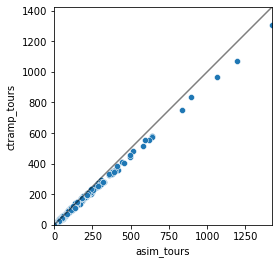

In [145]:
lim = pd.melt(omaz_compare).value.max()
fig, ax = plt.subplots()
sns.scatterplot(data=omaz_compare, x='asim_tours', y='ctramp_tours')
plt.axline((0, 0), slope=1, color='k', alpha=0.5)
plt.xlim(0,lim)
plt.ylim(0,lim)
ax.set_aspect(1)

### Tour MAZ Destination Counts

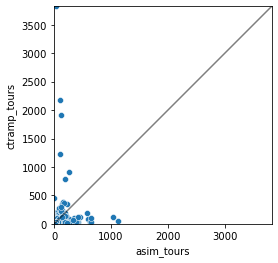

In [146]:
lim = pd.melt(dtaz_compare).value.max()
fig, ax = plt.subplots()
sns.scatterplot(data=dtaz_compare, x='asim_tours', y='ctramp_tours')
plt.axline((0, 0), slope=1, color='k', alpha=0.5)
plt.xlim(0,lim)
plt.ylim(0,lim)
ax.set_aspect(1)

### Top destination TAZ IDs

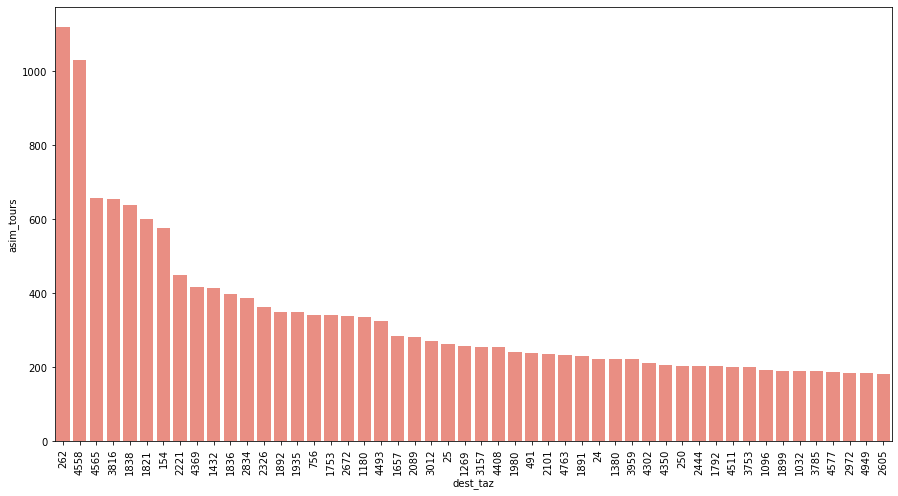

In [152]:
topdests = dtaz_compare.sort_values('asim_tours', ascending=False).head(50).reset_index()
plt.figure(figsize = (15,8))
ax = sns.barplot(data=topdests, x='dest_taz', y='asim_tours', 
                 order=topdests.sort_values('asim_tours', ascending=False).dest_taz,
                 color='salmon')
plt.xticks(rotation=90);

### Largest difference

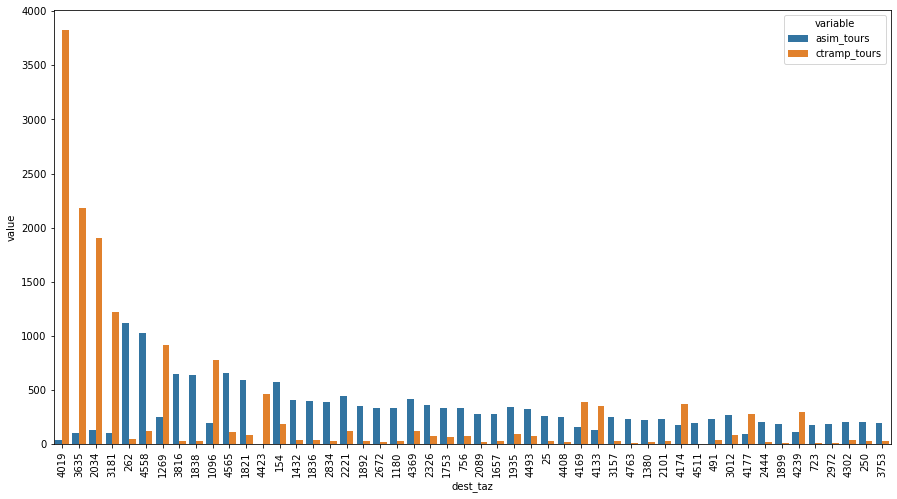

In [169]:
dest_diff = copy.deepcopy(dtaz_compare)
dest_diff['diff'] = (dtaz_compare.asim_tours - dtaz_compare.ctramp_tours).abs()
dest_diff = dest_diff.sort_values('diff', ascending=False).head(50).reset_index()


plt.figure(figsize = (15,8))
ax = sns.barplot(data=pd.melt(dest_diff, id_vars='dest_taz', value_vars=['asim_tours','ctramp_tours']),
                 x='dest_taz', y='value', hue='variable',
                order=dest_diff.dest_taz)
plt.xticks(rotation=90);

### Tour TAZ OD counts

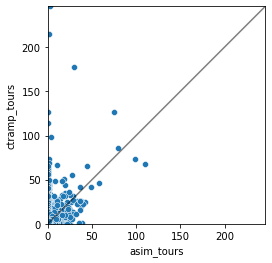

In [170]:
lim = pd.melt(odtaz_compare[['asim_tours','ctramp_tours']]).value.max()
fig, ax = plt.subplots()
sns.scatterplot(data=odtaz_compare, x='asim_tours', y='ctramp_tours')
plt.axline((0, 0), slope=1, color='k', alpha=0.5)
plt.xlim(0,lim)
plt.ylim(0,lim)
ax.set_aspect(1)

### Tour Distance by Tour Mode

In [171]:
asim_tours['intra_maz'] = asim_tours['origin'] == asim_tours['destination']
ctramp_tours['intra_maz'] = ctramp_tours['origin'] == ctramp_tours['destination']

In [172]:
asim_uniq_ods = asim_tours[['orig_taz','dest_taz']].drop_duplicates()
asim_uniq_ods['sov_dist'] = skims['SOV_NT_M_DIST__AM'][asim_uniq_ods['orig_taz'].values - 1, asim_uniq_ods['dest_taz'].values - 1]
asim_tours_w_dist = asim_tours.merge(asim_uniq_ods, left_on=['orig_taz', 'dest_taz'], right_on=['orig_taz','dest_taz'])

ctramp_uniq_ods = ctramp_tours[['orig_taz','dest_taz']].drop_duplicates()
ctramp_uniq_ods['sov_dist'] = skims['SOV_NT_M_DIST__AM'][ctramp_uniq_ods['orig_taz'].values - 1, ctramp_uniq_ods['dest_taz'].values - 1]
ctramp_tours_w_dist = ctramp_tours.merge(ctramp_uniq_ods, left_on=['orig_taz','dest_taz'], right_on=['orig_taz','dest_taz'])
asim_tours_w_dist.rename(columns={'primary_purpose': 'tour_purpose'}, inplace=True)

In [173]:
tour_dists = pd.concat((
    asim_tours_w_dist[['sov_dist','source','intra_maz', 'orig_taz', 'tour_mode', 'tour_purpose']],
    ctramp_tours_w_dist[['sov_dist','source','intra_maz', 'orig_taz', 'tour_mode', 'tour_purpose']]), ignore_index=True)

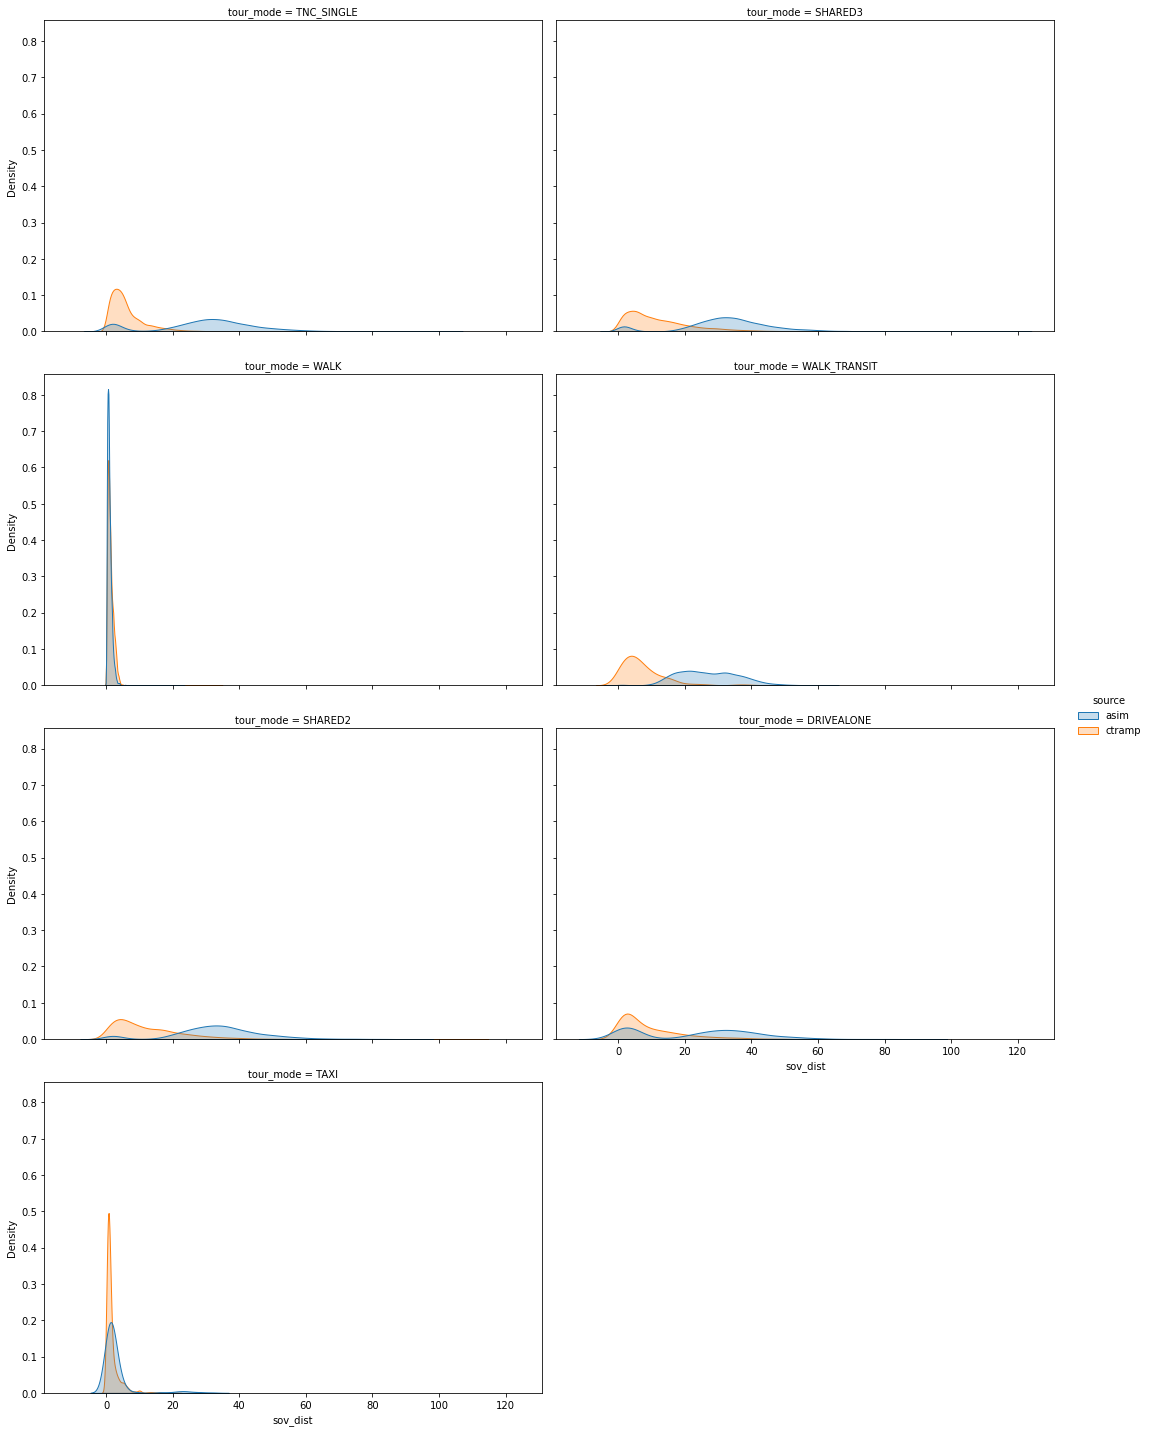

In [174]:
sns.displot(
        data=tour_dists, x='sov_dist', col='tour_mode',col_wrap=2, hue='source',
        kind='kde', fill=True, aspect=1.5, common_norm=False,
        facet_kws={'sharex': True, 'sharey': True, 'despine':False})

### Tour Distance by Tour Mode

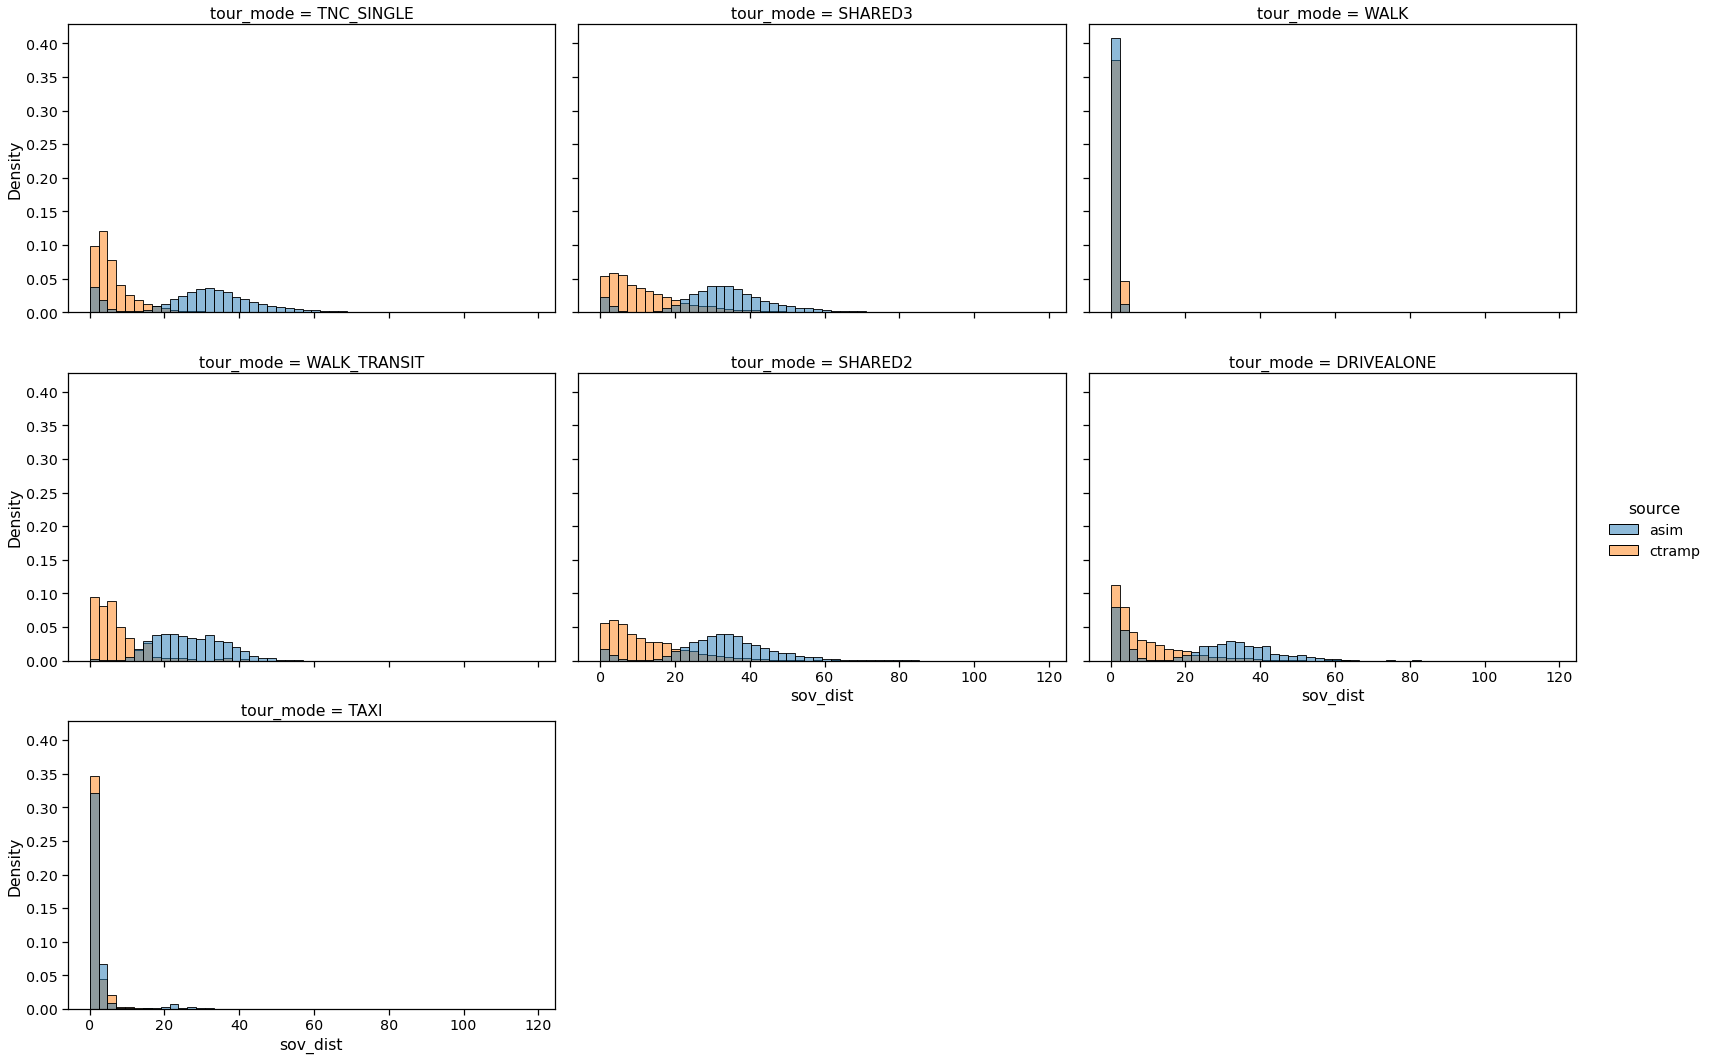

In [175]:
with sns.plotting_context("notebook",font_scale=1.3):
    sns.displot(
        data=tour_dists, x='sov_dist', col_wrap=3, col='tour_mode',hue='source',
        kind='hist', fill=True, aspect=1.5, common_norm=False,bins=50,stat='density',
        facet_kws={'sharex': True, 'sharey': True, 'despine':False, 'margin_titles':True})

### Tour Distance by Tour Purpose

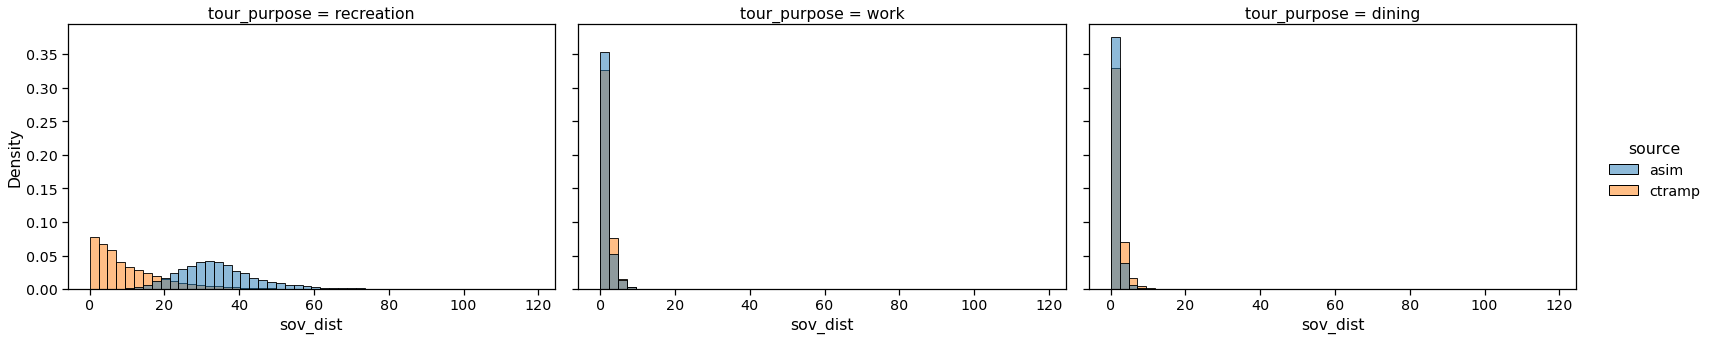

In [176]:
with sns.plotting_context("notebook",font_scale=1.3):
    sns.displot(
        data=tour_dists, x='sov_dist', col_wrap=3, col='tour_purpose',hue='source',
        kind='hist', fill=True, aspect=1.5, common_norm=False,bins=50,stat='density',
        facet_kws={'sharex': True, 'sharey': True, 'despine':False, 'margin_titles':True})

### Tour Distance by Intra-MAZ Tour Flag

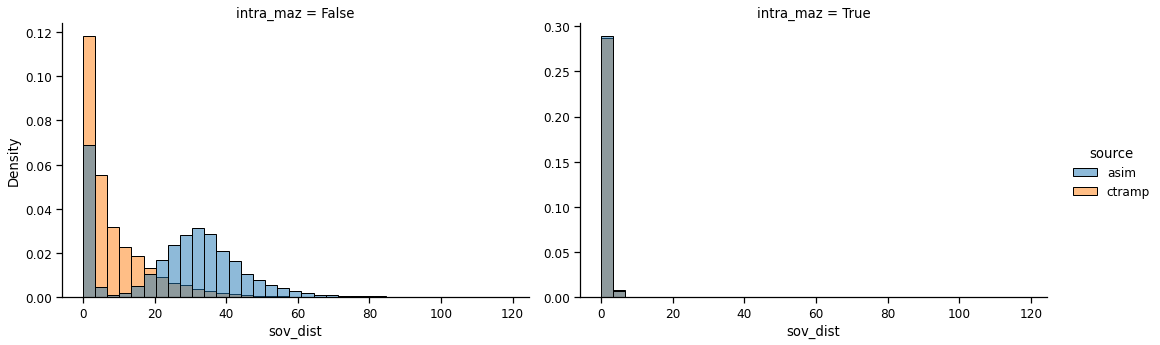

In [20]:
with sns.plotting_context("notebook",font_scale=1.1):
    sns.displot(
        data=tour_dists, x='sov_dist', col='intra_maz',hue='source', kind='hist', fill=True, aspect=1.5, bins=35,
        facet_kws={'sharex': False, 'sharey': False}, stat='density', common_norm=False)

## Tour Mode Choice

Text(0.5, 0, 'tour mode')

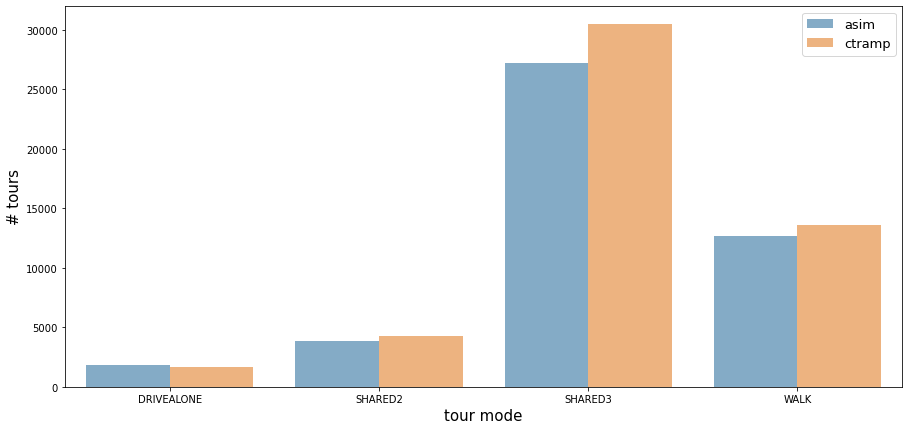

In [21]:
fig, ax = plt.subplots(figsize=(15,7))
tour_mode = asim_tours.groupby('tour_mode')['tour_id'].count()
tour_mode = pd.merge(tour_mode, ctramp_tours.groupby('tour_mode')['id'].count(), left_index=True, right_index=True).reset_index()
tour_mode.columns = ['tour_mode','asim','ctramp']
tour_mode = tour_mode.melt(id_vars='tour_mode',var_name='source',value_name='num_tours')
sns.barplot(
    data=tour_mode, x='tour_mode', y='num_tours', order=['DRIVEALONE','SHARED2','SHARED3','WALK'],
    hue='source', ax=ax, alpha=0.6)
ax.legend(fontsize=13)
ax.set_ylabel('# tours', fontsize=15)
ax.set_xlabel('tour mode', fontsize=15)

In [22]:
tour_mode_purpose = pd.merge(
    asim_tours.groupby(['tour_mode','primary_purpose']).size().reset_index(name='asim_tours'),
    ctramp_tours.groupby(['tour_mode','tour_purpose']).size().reset_index(name='ctramp_tours'),
    left_on=['tour_mode','primary_purpose'],
    right_on=['tour_mode','tour_purpose'],
    how='outer'
).fillna(0).drop(columns='primary_purpose')
tour_mode_purpose = pd.melt(tour_mode_purpose, id_vars=['tour_mode','tour_purpose'], var_name='source', value_name='num_tours')

### Tour Mode by Tour Purpose

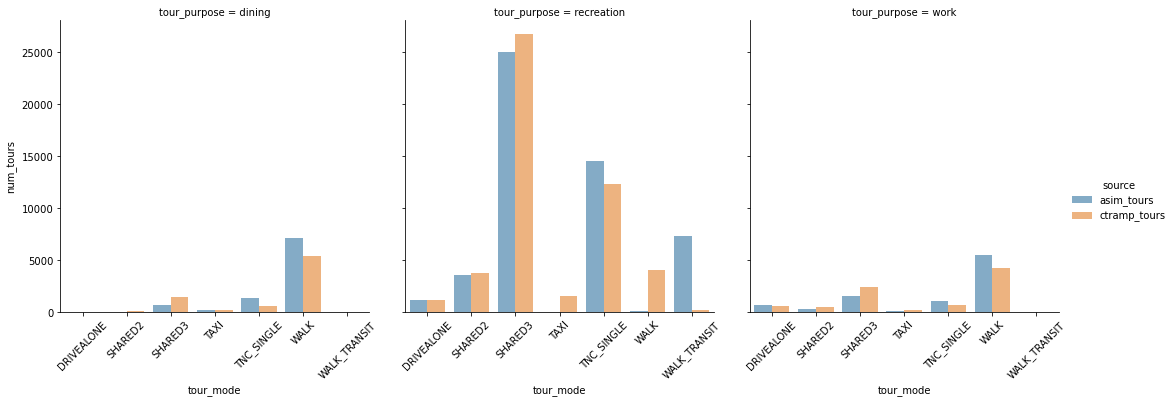

In [23]:
g = sns.catplot(
    data=tour_mode_purpose, x='tour_mode', y='num_tours', kind='bar',
    col='tour_purpose', col_wrap=3,hue='source', alpha=0.6, sharey=True)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)

## Stop Frequency

In [24]:
asim_tpt = asim_trips.groupby(['tour_id'])['trip_id'].count().value_counts().reset_index()
asim_tpt.columns = ['# trips', '# tours']
asim_tpt['source'] = 'asim'

In [25]:
ctramp_tpt = ctramp_trips.groupby(['tourID'])['tripID'].count().value_counts().reset_index()
ctramp_tpt.columns = ['# trips', '# tours']
ctramp_tpt['source'] = 'ctramp'

In [26]:
all_tpt = pd.concat([asim_tpt,ctramp_tpt])

Text(0.5, 0, 'trips per tour')

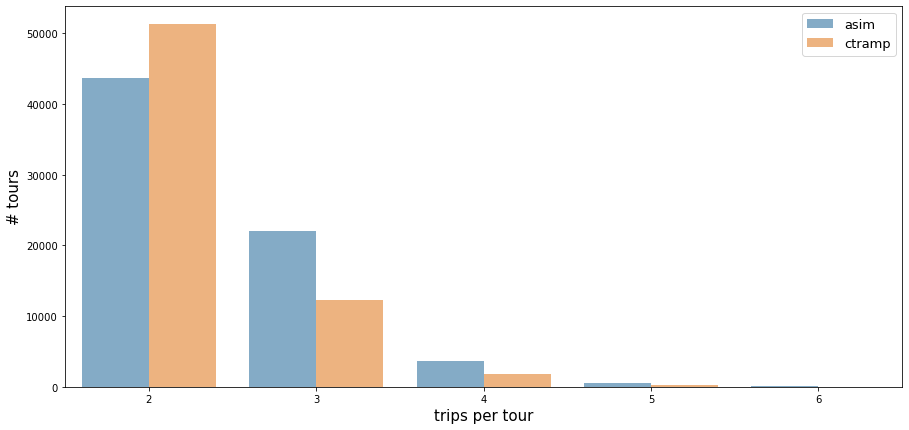

In [27]:
fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(data=all_tpt, x='# trips', y='# tours', hue='source', ax=ax, alpha=0.6)
ax.legend(fontsize=13)
ax.set_ylabel('# tours', fontsize=15)
ax.set_xlabel('trips per tour', fontsize=15)

## Trip Purpose 

In [28]:
asim_purp = asim_trips.groupby(['purpose'])['trip_id'].count().reset_index()
asim_purp.columns = ['purpose', '# trips']
asim_purp['source'] = 'asim'

In [29]:
ctramp_purp = ctramp_trips.groupby(['dest_purpose'])['tripID'].count().reset_index()
ctramp_purp.columns = ['purpose', '# trips']
ctramp_purp['source'] = 'ctramp'

In [30]:
all_purp = pd.concat([asim_purp, ctramp_purp])

Text(0.5, 0, 'trip purpose')

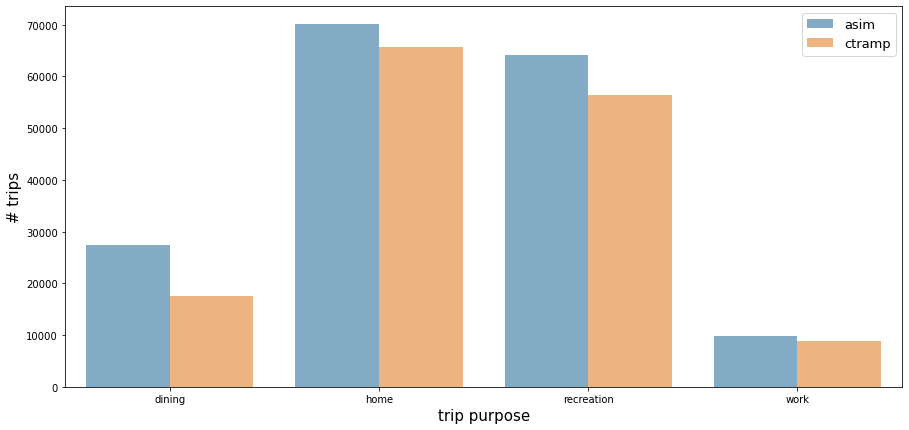

In [31]:
fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(data=all_purp, x='purpose', y='# trips', hue='source', ax=ax, alpha=0.6)
ax.legend(fontsize=13)
ax.set_ylabel('# trips', fontsize=15)
ax.set_xlabel('trip purpose', fontsize=15)

### Trips per Tour by Trip Purpose 

In [32]:
asim_tpt = asim_trips.groupby(['tour_id', 'purpose'])['trip_id'].count().reset_index()
asim_tpt.rename(columns={'trip_id': 'trips per tour', 'tour_id': '# tours', 'purpose': 'trip purpose'}, inplace=True)
asim_tpt = asim_tpt.groupby(['trip purpose', 'trips per tour']).count().reset_index()
asim_tpt['source'] = 'asim'

In [33]:
ctramp_tpt = ctramp_trips.groupby(['tourID', 'dest_purpose'])['tripID'].count().reset_index()
ctramp_tpt.rename(columns={'tripID': 'trips per tour', 'tourID': '# tours', 'dest_purpose': 'trip purpose'}, inplace=True)
ctramp_tpt = ctramp_tpt.groupby(['trip purpose', 'trips per tour']).count().reset_index()
ctramp_tpt['source'] = 'ctramp'

In [34]:
all_tpt = pd.concat([asim_tpt, ctramp_tpt])

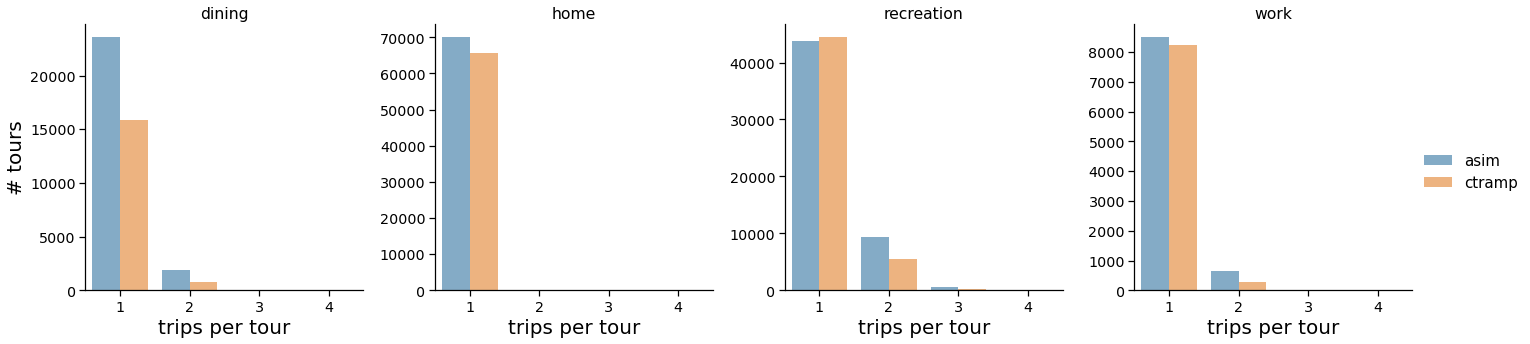

In [35]:
with sns.plotting_context("notebook",font_scale=1.3):
    g = sns.catplot(
        data=all_tpt, x='trips per tour', y='# tours', kind='bar', hue='source', col='trip purpose',
        col_wrap=4, sharey=False, alpha=0.6)
    g._legend.set_title('')
    plt.setp(g._legend.get_texts(), fontsize=15)
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("trips per tour", "# tours", fontsize=20)

## Trip Scheduling 

Text(0.5, 0, 'trip departure hour')

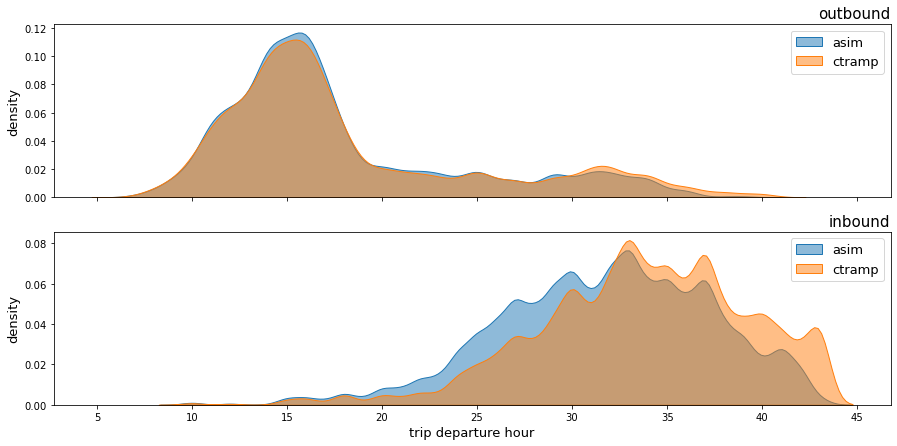

In [36]:
fig, axarr = plt.subplots(figsize=(15,7), nrows=2, sharex=True)
sns.kdeplot(data=asim_trips[asim_trips['outbound']], x='depart', ax=axarr[0], label='asim', alpha=0.5, shade=True)
sns.kdeplot(data=ctramp_trips[~ctramp_trips['inbound']], x='period', ax=axarr[0], label='ctramp', alpha=0.5, shade=True)
axarr[0].legend(fontsize=13)
axarr[0].set_ylabel('density', fontsize=13)
axarr[0].set_xlabel('')
axarr[0].set_title('outbound', fontsize=15, loc='right')
axarr[1].set_title('inbound', fontsize=15, loc='right')
sns.kdeplot(data=asim_trips[~asim_trips['outbound']], x='depart', ax=axarr[1], label='asim', alpha=0.5, shade=True)
sns.kdeplot(data=ctramp_trips[ctramp_trips['inbound']], x='period', ax=axarr[1], label='ctramp', alpha=0.5, shade=True)
axarr[1].legend(fontsize=13)
axarr[1].set_ylabel('density', fontsize=13)
axarr[1].set_xlabel('trip departure hour', fontsize=13)

## Trip Destination 

In [37]:
asim_trips['dest_pseudomsa'] = asim_trips['destination'].map(maz_to_msa)
asim_trips['orig_pseudomsa'] = asim_trips['origin'].map(maz_to_msa)
ctramp_trips['dest_pseudomsa'] = ctramp_trips['destination'].map(maz_to_msa)
ctramp_trips['orig_pseudomsa'] = ctramp_trips['origin'].map(maz_to_msa)

### Trip ODs

In [38]:
asim_trip_ods = asim_trips.groupby(['orig_pseudomsa','dest_pseudomsa'])['trip_id'].count().reset_index()
asim_trip_ods.columns=['origin pMSA', 'destination pMSA', '# trips']
asim_trip_ods = asim_trip_ods.pivot(index='origin pMSA', columns='destination pMSA',values='# trips')
ctramp_trip_ods = ctramp_trips.groupby(['orig_pseudomsa','dest_pseudomsa'])['tripID'].count().reset_index()
ctramp_trip_ods.columns=['origin pMSA', 'destination pMSA', '# trips']
ctramp_trip_ods = ctramp_trip_ods.pivot(index='origin pMSA', columns='destination pMSA',values='# trips')

Text(0.5, 0.98, 'Trip OD Counts')

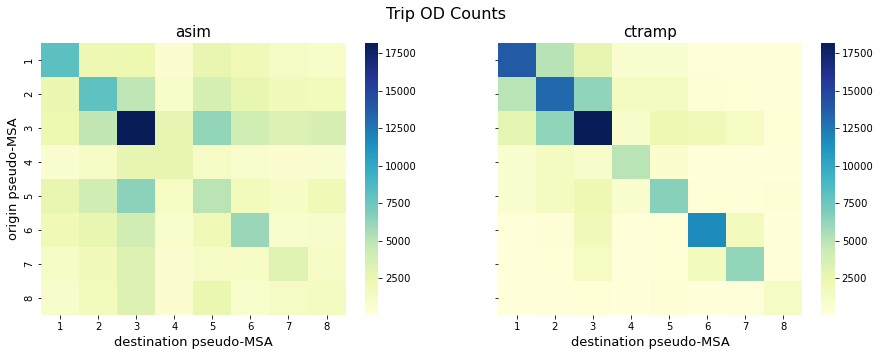

In [39]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5))
vmin = min(asim_trip_ods.min().min(), ctramp_trip_ods.min().min())
vmax = min(asim_trip_ods.max().max(), ctramp_trip_ods.max().max())

sns.heatmap(
    asim_trip_ods, ax=ax[0], cmap="YlGnBu", cbar=True,
    vmin=vmin, vmax=vmax,
#     norm=LogNorm()
)
g = sns.heatmap(
    ctramp_trip_ods, ax=ax[1],cmap="YlGnBu", cbar=True,
    vmin=vmin, vmax=vmax,
#     norm=LogNorm()
)
ax[0].set_title('asim', fontsize=15)
ax[0].set_ylabel('origin pseudo-MSA', fontsize=13)
ax[0].set_xlabel('destination pseudo-MSA', fontsize=13)
ax[1].set_title('ctramp', fontsize=15)
ax[1].set_ylabel('')
ax[1].set_xlabel('destination pseudo-MSA', fontsize=13)
fig.suptitle('Trip OD Counts', fontsize=16)

In [40]:
asim_trip_dest_tazs = asim_trips[asim_trips['trip_num'] != asim_trips['trip_count']].groupby('dest_taz')['trip_id'].count().reset_index()
asim_trip_dest_tazs.rename(columns={'trip_id':'asim_count'}, inplace=True)

ctramp_trip_dest_tazs = ctramp_trips[(~ctramp_trips['destinationIsTourDestination']) & (ctramp_trips['destPurp'] >= 0)].groupby('dest_taz')['tripID'].count().reset_index()
ctramp_trip_dest_tazs.rename(columns={'tripID':'ctramp_count'}, inplace=True)

trip_dest_tazs = pd.merge(asim_trip_dest_tazs, ctramp_trip_dest_tazs, left_on='dest_taz',right_on='dest_taz', how='outer').fillna(0)

Text(0, 0.5, 'ctramp')

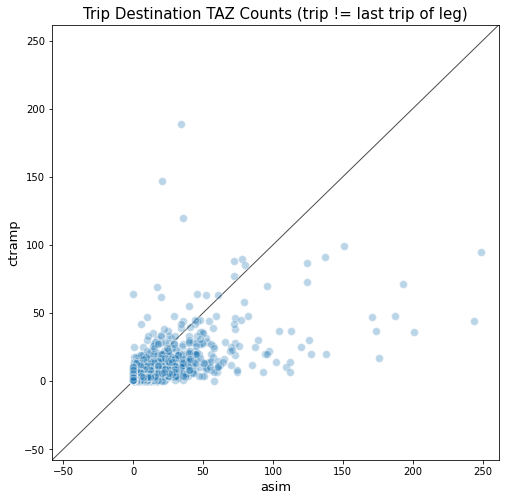

In [41]:
fig, ax = plt.subplots(figsize=(8,8))
g = sns.scatterplot(data=trip_dest_tazs, x='asim_count', y='ctramp_count',ax=ax, marker='.',alpha=0.3, s=250)
min_bound = min(ax.get_xlim()[0], ax.get_ylim()[0])
max_bound = min(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([min_bound, max_bound], [min_bound, max_bound], linewidth=1, alpha=0.7, c='k', zorder=0)
ax.set_title('Trip Destination TAZ Counts (trip != last trip of leg)', fontsize=15)
ax.set_xlim(min_bound, max_bound)
ax.set_ylim(min_bound, max_bound)
ax.set_xlabel('asim',fontsize=13)
ax.set_ylabel('ctramp', fontsize=13)

### Trip Distance

In [42]:
asim_uniq_ods = asim_trips[['orig_taz', 'dest_taz']].drop_duplicates()
asim_uniq_ods['sov_dist'] = skims['SOV_NT_M_DIST__AM'][asim_uniq_ods['orig_taz'].values - 1, asim_uniq_ods['dest_taz'].values - 1]

ctramp_uniq_ods = ctramp_trips[['orig_taz', 'dest_taz']].drop_duplicates()
ctramp_uniq_ods['sov_dist'] = skims['SOV_NT_M_DIST__AM'][ctramp_uniq_ods['orig_taz'].values - 1, ctramp_uniq_ods['dest_taz'].values - 1]

asim_trips_w_dist = asim_trips.merge(asim_uniq_ods, left_on=['orig_taz', 'dest_taz'], right_on=['orig_taz','dest_taz'])
ctramp_trips_w_dist = ctramp_trips.merge(ctramp_uniq_ods, left_on=['orig_taz','dest_taz'], right_on=['orig_taz','dest_taz'])

In [43]:
asim_disc_mask = asim_trips_w_dist['trip_num'].between(1, asim_trips_w_dist['trip_count'], inclusive='neither')
asim_disc_trips = asim_trips_w_dist[asim_disc_mask]

In [44]:
ctramp_disc_mask = (
    ctramp_trips_w_dist['destination'] != ctramp_trips_w_dist['destinationMGRA_tour']) & (
    ctramp_trips_w_dist['destination'] != ctramp_trips_w_dist['originMGRA_tour']) & (
    ctramp_trips_w_dist['origin'] != ctramp_trips_w_dist['destinationMGRA_tour']) & (
    ctramp_trips_w_dist['origin'] != ctramp_trips_w_dist['originMGRA_tour']
)
ctramp_disc_trips = ctramp_trips_w_dist[ctramp_disc_mask]

Text(0.5, 1.0, 'Trip Distance (all trips)')

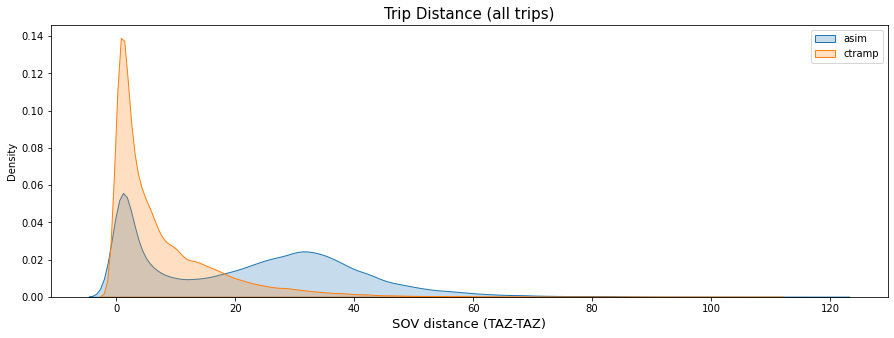

In [45]:
fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(asim_trips_w_dist['sov_dist'], label='asim', ax=ax, fill=True)
sns.kdeplot(ctramp_trips_w_dist['sov_dist'], label='ctramp', ax=ax, fill=True)
ax.legend()
ax.set_xlabel('SOV distance (TAZ-TAZ)', fontsize=13)
ax.set_title('Trip Distance (all trips)', fontsize=15)

Text(0.5, 1.0, 'Trip Distance (non-tour-OD trips)')

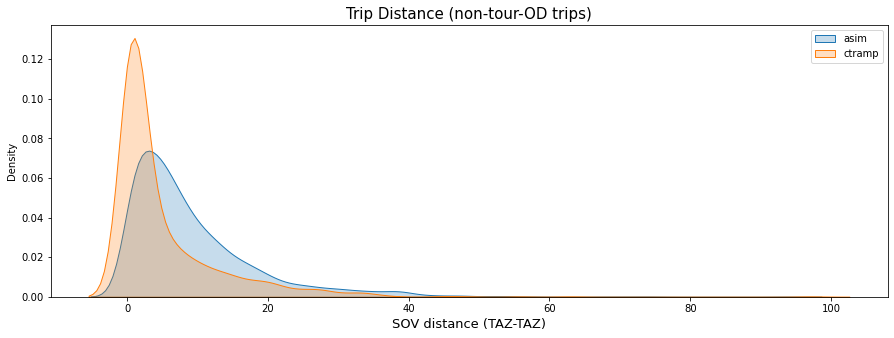

In [46]:
fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(asim_disc_trips['sov_dist'], label='asim', ax=ax, fill=True)
sns.kdeplot(ctramp_disc_trips['sov_dist'], label='ctramp', ax=ax, fill=True)
ax.legend()
ax.set_xlabel('SOV distance (TAZ-TAZ)', fontsize=13)
ax.set_title('Trip Distance (non-tour-OD trips)', fontsize=15)

## Trip Mode

Text(0.5, 0, 'trip mode')

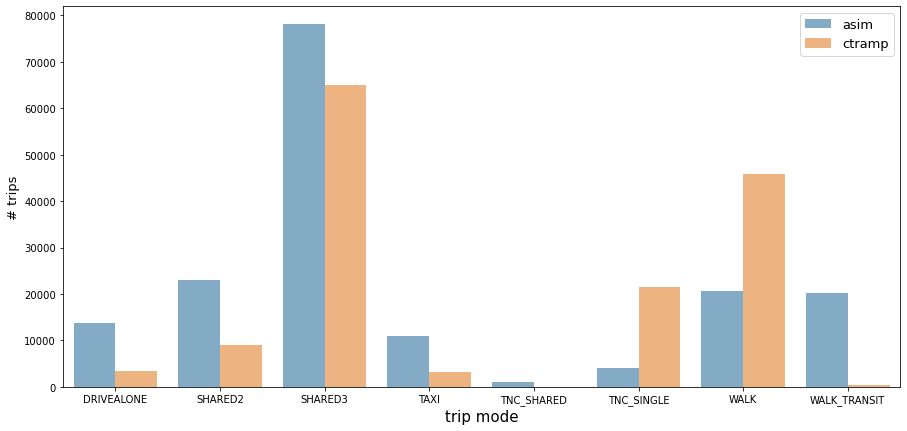

In [47]:
fig, ax = plt.subplots(figsize=(15,7))
trip_mode = asim_trips.groupby('trip_mode')['trip_id'].count()
trip_mode = pd.merge(
    trip_mode, ctramp_trips.groupby('trip_mode')['tripID'].count(),
    left_index=True, right_index=True, how='outer').reset_index()
trip_mode.columns = ['trip_mode','asim','ctramp']
trip_mode = trip_mode.melt(id_vars='trip_mode',var_name='source',value_name='num_trips')
g = sns.barplot(
    data=trip_mode, x='trip_mode', y='num_trips', 
    hue='source', ax=ax, alpha=0.6)
ax.legend(fontsize=13)
ax.set_ylabel('# trips', fontsize=13)
ax.set_xlabel('trip mode', fontsize=15)

###  Trip Mode by Tour Mode

In [48]:
trip_mode = asim_trips.groupby(['trip_mode','tour_mode'])['trip_id'].count().fillna(0)
trip_mode = pd.merge(
    trip_mode, ctramp_trips.groupby(['trip_mode','tour_mode'])['tripID'].count().fillna(0),
    left_index=True, right_index=True, how='outer').reset_index()
trip_mode.columns = ['trip_mode','tour_mode','asim','ctramp']
trip_mode_long = trip_mode.melt(id_vars=['trip_mode','tour_mode'],var_name='source',value_name='num_trips').fillna(0)

tour_mode_sums = trip_mode_long.groupby(['tour_mode', 'source'])['num_trips'].sum().reset_index()
tour_mode_sums.rename(columns={'num_trips': 'total_trips'}, inplace=True)
trip_mode_long = trip_mode_long.merge(tour_mode_sums, on=['tour_mode','source'])

trip_mode_long['pct_trips'] = trip_mode_long['num_trips'] / trip_mode_long['total_trips']

In [49]:
# with sns.plotting_context("notebook",font_scale=1.3):
#     g = sns.catplot(
#         data=trip_mode_long, x='trip_mode', y='num_trips', col='tour_mode', col_wrap=2, kind='bar',
#         hue='source',alpha=0.6, aspect=1.5, facet_kws={'despine':False})
#     # g.set_yscale("log")
#     g._legend.set_title('')
#     plt.setp(g._legend.get_texts(), fontsize=15)
#     g.set_axis_labels("trip mode", "# trips", fontsize=20)
#     g.fig.subplots_adjust(top=0.9)
#     g.fig.suptitle('Trip Mode by Tour Mode (total)')
#     for ax in g.axes.ravel():
#         ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

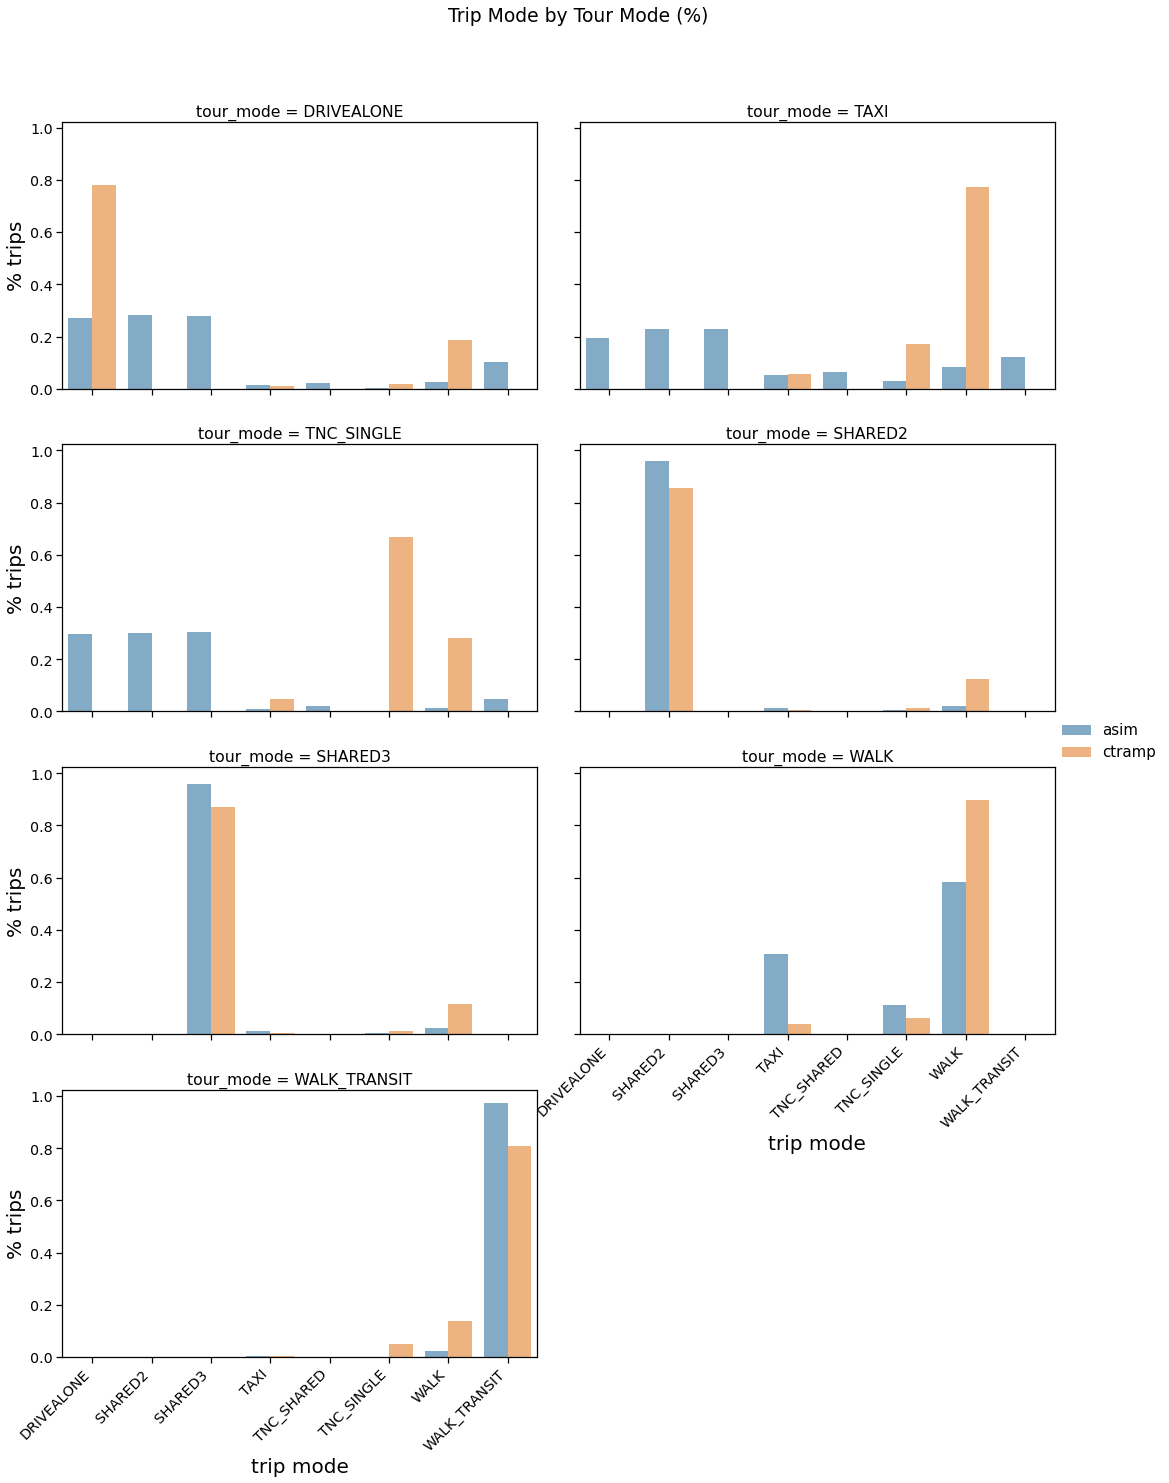

In [50]:
with sns.plotting_context("notebook",font_scale=1.3):
    g = sns.catplot(
        data=trip_mode_long, x='trip_mode', y='pct_trips', col='tour_mode', col_wrap=2, kind='bar',
        hue='source',alpha=0.6, aspect=1.5, facet_kws={'despine':False})
    # g.set_yscale("log")
    g._legend.set_title('')
    plt.setp(g._legend.get_texts(), fontsize=15)
    g.set_axis_labels("trip mode", "% trips", fontsize=20)
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('Trip Mode by Tour Mode (%)')
    for ax in g.axes.ravel():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

### Trip Distance by Trip Mode

In [51]:
trip_dist_by_mode = pd.concat(
    (asim_trips_w_dist[['trip_mode','sov_dist','source']], ctramp_trips_w_dist[['trip_mode','sov_dist','source']]), names=['asim','ctramp'])

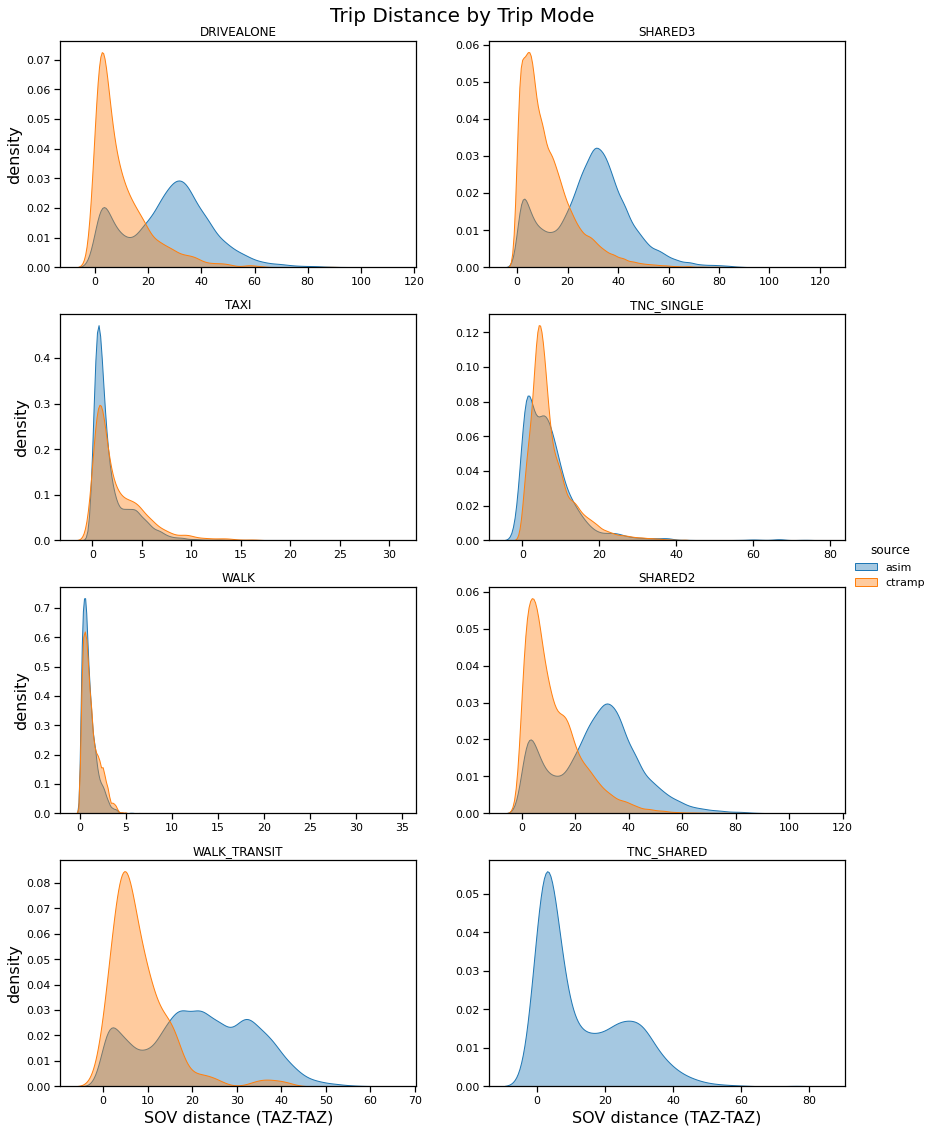

In [52]:
with sns.plotting_context("notebook",font_scale=1):
    g = sns.FacetGrid(trip_dist_by_mode, col="trip_mode", col_wrap=2, hue='source',
                      height=4, aspect=1.5,sharex=False, sharey=False, despine=False)
    g.map(sns.kdeplot, "sov_dist", fill=True, alpha=0.4)
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("SOV distance (TAZ-TAZ)", "density", fontsize=16)
    g.add_legend()
    g.fig.subplots_adjust(top=0.95)
    g.fig.suptitle('Trip Distance by Trip Mode',fontsize=20)